In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
pd.options.display.float_format = '{:.2f}'.format

## Read in data files and parse dates

## Google Drive storage location for date-limited data files:
https://drive.google.com/open?id=0B_PnWx1pRhmzNWxYNDVjWjBNcnc

crime_df source data:
https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-present/ijzp-q8t2

weather_df source data:
www.wunderground.com/history

[astronomics] ---not yet a part of this base file; please update with how it's being used
http://aa.usno.navy.mil/data/index.php

In [2]:
# Make sure data files are in the same folder
# Add any additional read-in statements here
# This takes a while because of the datetime conversion in crime_df (over a million lines)

weather_df = pd.read_csv("Chicago Weather Data 2011-2015.txt")
weather_df.rename(columns={'CST':'Date'}, inplace=True)
weather_df['Date'] = pd.to_datetime(weather_df['Date']).dt.date

crime_df = pd.read_csv("Chicago Crime 2011-2015.csv")
crime_df['Date'] = pd.to_datetime(crime_df['Date']).dt.date

## weather_df modifications

Since weather_df is already organized as a single day for every line, it is useful to add columns that will make
further analysis easier.

In [3]:
# Some columns in weather_df get imported with a leading space
# This removes those spaces

newcols = []
for i in weather_df.columns:
    if i[0] == ' ':
        i = i[1:]
    newcols.append(i)

weather_df.columns = newcols

In [4]:
# Mapping function so that temps can be categorized into buckets
def temp_map(temp):
    if temp < 0:
        return 'below 0'
    else:
        return str((temp//10)*10) + 's'
    
# Apply map to new column
weather_df['temp bucket'] = weather_df['Max TemperatureF'].map(temp_map)

In [5]:
# weatherunderground uses a scale of 0 to 9 to represent cloud cover
# I'm saying that a "clear" day is one with a cloud cover of less than 3
weather_df['Clear'] = weather_df['CloudCover'].map(lambda x: int(x) < 3)

In [6]:
# Create a list of each unique weather event type
eventlist = list(weather_df['Events'].unique())
neweventlist = []
for i in eventlist:
    i = str(i)
    neweventlist.append(i.split('-'))
eventlist = []
for i in neweventlist:
    for j in i:
        if j != 'nan':
            eventlist.append(j)
eventlist = list(set(eventlist))

# Create a new column in the weather dataframe for each item in the event list and populate with True or False for each day
for e in eventlist:
    weather_df[e] = weather_df['Events'].map(lambda x: e in str(x))

In [7]:
# Crimes per day seems like a pretty good thing to throw in there
dailycounts = crime_df.groupby('Date').size()
weather_df['crimes'] = weather_df.Date.map(lambda x: dailycounts[x])

In [8]:
# A 'local' average is useful for picking out days that deviate from their immediately adjacent neighbors
# The local deviation is how each day compares to its neighbors
def get_local_avg(date,span=7,df=weather_df):
    return df[(df['Date'] < date + datetime.timedelta(days=span/2)) & 
              (df['Date'] > date - datetime.timedelta(days=span/2)) &
              (df['Date'] != date)]['crimes'].mean()

weather_df['localavg'] = weather_df.Date.map(get_local_avg)
weather_df['localdeviation'] = weather_df['crimes']/weather_df['localavg'] - 1

In [9]:
# It's useful to be able to reference the day of the month readily
weather_df['day'] = weather_df.Date.map(lambda x: x.day)

In [10]:
# It's also useful to know which day of the week it is
weather_df['dow'] = weather_df.Date.map(lambda x: x.weekday())

## Merge DataFrames

In [11]:
# Left-join crime and weather dataframes (crime on the left)
# We are able to merge on the date because the date field in both dataframes was groomed the same way above
combined = pd.merge(crime_df, weather_df, how='left', on='Date')

In [12]:
combined.columns

Index(['Date', 'Block', 'Primary Type', 'Description', 'Location Description',
       'Arrest', 'Domestic', 'District', 'FBI Code', 'Max TemperatureF',
       'Mean TemperatureF', 'Min TemperatureF', 'Max Dew PointF',
       'MeanDew PointF', 'Min DewpointF', 'Max Humidity', 'Mean Humidity',
       'Min Humidity', 'Max Sea Level PressureIn', 'Mean Sea Level PressureIn',
       'Min Sea Level PressureIn', 'Max VisibilityMiles',
       'Mean VisibilityMiles', 'Min VisibilityMiles', 'Max Wind SpeedMPH',
       'Mean Wind SpeedMPH', 'Max Gust SpeedMPH', 'PrecipitationIn',
       'CloudCover', 'Events', 'WindDirDegrees', 'temp bucket', 'Clear',
       'Hail', 'Snow', 'Thunderstorm', 'Fog', 'Rain', 'crimes', 'localavg',
       'localdeviation', 'day', 'dow'],
      dtype='object')

# 1) Is crime more likely in warm or cold weather?

(Scott)

In [13]:
# Let's build a dataframe to start looking at each temperature bucket

temp_bucket_df_index = ['below 0', '0s', '10s', '20s', '30s', '40s', '50s', '60s', '70s', '80s', '90s', '100s']
temp_bucket_df_columns = ['Day Count', 'Crime Rate']
temp_bucket_df = pd.DataFrame(index=temp_bucket_df_index, columns=temp_bucket_df_columns)

temp_bucket_df.head(1)

,Day Count,Crime Rate
below 0,NaN,NaN


In [14]:
# A few mapping functions will allow us to populate the counts and rates for each bucket

def daycount(bucket,event='',col='temp bucket',df=weather_df):
    '''Pass in a temperature bucket to receive back the number of days with a matching high temp.
    By using the optional event input, you can specify a second criteria'''
    
    if event == '':
        return len(df[df[col] == bucket])
    else:
        return len(df[(df[col] == bucket) & (df[event])])
    
def crimerate(bucket,event='',days_func=daycount,col='temp bucket',df=combined):
    '''Pass in a temperature bucket to receive back the crime rate for that given temp range.
    As with daycount, an event may be specified to further define the criteria.
    This function relies on the daycount function to find the denomiator for the rate calculation'''
    
    if days_func(bucket,event) == 0:
        return np.nan
    if event == '':
        return len(df[df[col] == bucket]) / days_func(bucket)
    else:
        return len(df[(df[col] == bucket) & (df[event])]) / days_func(bucket,event)

In [15]:
# Apply the mapping functions above to start getting actual data into the new dataframe
temp_bucket_df.index.name = 'Temp Bucket'
temp_bucket_df['Day Count'] = temp_bucket_df.index.map(daycount)
temp_bucket_df['Crime Rate'] = temp_bucket_df.index.map(crimerate)

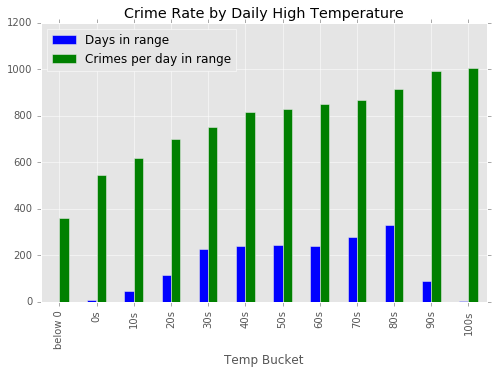

In [16]:
plt.style.use('ggplot')
temp_bucket_df.plot(kind='bar', title='Crime Rate by Daily High Temperature', 
                    figsize=(8,5)).legend(['Days in range','Crimes per day in range'], loc='upper left')

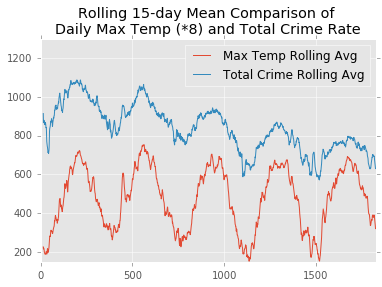

In [61]:
weather_df.columns
pd.rolling_mean(weather_df['Max TemperatureF'] * 8, 15).plot()
pd.rolling_mean(weather_df['crimes'], 15).plot()
plt.ylim((150, 1300))
plt.legend(['Max Temp Rolling Avg', 'Total Crime Rolling Avg'])
plt.title('Rolling 15-day Mean Comparison of \nDaily Max Temp (*8) and Total Crime Rate')

# 2) Is crime more likely during pleasant or stormy weather?

(Scott)

In [17]:
# Gathering basic info - total number of days in dataset and the number of days on which each event type occurred

days = len(weather_df)

# Can filter by simply calling the column, since each of the event columns contains a True or a False
daycounts = {
    'Thunderstorm': len(weather_df[weather_df['Thunderstorm']]),
    'Hail': len(weather_df[weather_df['Hail']]),
    'Snow': len(weather_df[weather_df['Snow']]),
    'Rain': len(weather_df[weather_df['Rain']]),
    'Fog': len(weather_df[weather_df['Fog']]),
    'Clear': len(weather_df[weather_df['Clear']])
    }
print(days)
print(daycounts)

1826
{'Hail': 3, 'Clear': 293, 'Thunderstorm': 191, 'Rain': 608, 'Fog': 93, 'Snow': 273}


In [18]:
# Plucking out the frequency of each primary crime type (rate) for the presence or absense of each event type
# No special reason to run count() on dates, it's just one option that works
freq_no_thunder = combined[combined['Thunderstorm'] == False].groupby('Primary Type')['Date'].count()/(days - daycounts['Thunderstorm'])
freq_yes_thunder = combined[combined['Thunderstorm'] == True].groupby('Primary Type')['Date'].count()/daycounts['Thunderstorm']

freq_no_hail = combined[combined['Hail'] == False].groupby('Primary Type')['Date'].count()/(days - daycounts['Hail'])
freq_yes_hail = combined[combined['Hail'] == True].groupby('Primary Type')['Date'].count()/daycounts['Hail']

freq_no_snow = combined[combined['Snow'] == False].groupby('Primary Type')['Date'].count()/(days - daycounts['Snow'])
freq_yes_snow = combined[combined['Snow'] == True].groupby('Primary Type')['Date'].count()/daycounts['Snow']

freq_no_rain = combined[combined['Rain'] == False].groupby('Primary Type')['Date'].count()/(days - daycounts['Rain'])
freq_yes_rain = combined[combined['Rain'] == True].groupby('Primary Type')['Date'].count()/daycounts['Rain']

freq_no_fog = combined[combined['Fog'] == False].groupby('Primary Type')['Date'].count()/(days - daycounts['Fog'])
freq_yes_fog = combined[combined['Fog'] == True].groupby('Primary Type')['Date'].count()/daycounts['Fog']

freq_not_clear = combined[combined['Clear'] == False].groupby('Primary Type')['Date'].count()/(days - daycounts['Clear'])
freq_clear = combined[combined['Clear'] == True].groupby('Primary Type')['Date'].count()/(daycounts['Clear'])

In [19]:
# Constructing a dataframe to capture the "effect" of an event, which I am defining to be the crime rate
# during an event divided by the crime rate in the absense of that event.
thunder_comparison = pd.concat([freq_no_thunder, freq_yes_thunder],axis=1)
thunder_comparison.columns=['no thunder','thunder']
thunder_comparison['thunder effect'] = ((thunder_comparison['thunder'] / thunder_comparison['no thunder']) - 1) * 100

hail_comparison = pd.concat([freq_no_hail, freq_yes_hail],axis=1)
hail_comparison.columns=['no hail','hail']
hail_comparison['hail effect'] = ((hail_comparison['hail'] / hail_comparison['no hail']) - 1) * 100

snow_comparison = pd.concat([freq_no_snow, freq_yes_snow],axis=1)
snow_comparison.columns=['no snow','snow']
snow_comparison['snow effect'] = ((snow_comparison['snow'] / snow_comparison['no snow']) - 1) * 100

rain_comparison = pd.concat([freq_no_rain, freq_yes_rain],axis=1)
rain_comparison.columns=['no rain','rain']
rain_comparison['rain effect'] = ((rain_comparison['rain'] / rain_comparison['no rain']) - 1) * 100

fog_comparison = pd.concat([freq_no_fog, freq_yes_fog],axis=1)
fog_comparison.columns=['no fog','fog']
fog_comparison['fog effect'] = ((fog_comparison['fog'] / fog_comparison['no fog']) - 1) * 100

clear_comparison = pd.concat([freq_not_clear, freq_clear],axis=1)
clear_comparison.columns=['not clear','clear']
clear_comparison['clear effect'] = ((clear_comparison['clear'] / clear_comparison['not clear']) - 1) * 100

In [20]:
# Putting it all together
# hail_comparison['hail effect'] removed because there are only 3 days with hail - too insignificant
comparison_df = pd.concat([thunder_comparison['thunder effect'], clear_comparison['clear effect'], 
                          rain_comparison['rain effect'], fog_comparison['fog effect'],
                          snow_comparison['snow effect']], axis = 1)

In [21]:
# Building a dictionary to capture the 'sample size' for each primary type to help restrict findings
# to those that are significant
primary_types = list(combined['Primary Type'].unique())
type_counts = {}
for i in primary_types:
    type_counts[i] = len(combined[combined['Primary Type'] == i])
    
# Add the sample size values from above into its own column so it can be sorted in descending order
# (Most frequent crime on top)
comparison_df['sample size'] = comparison_df.index.map(lambda x: type_counts[x])
comparison_df.sort_values(by='sample size', ascending=[1], inplace=True)

# Just naming the index column so that it auto-populates the axis label in the plot
comparison_df.index.names = ['Primary Type']

In [22]:
# New instance of the comparison DF ommitting anything with a 'small' sample size
comparison_df_truncated = comparison_df[comparison_df['sample size'] > 1000]

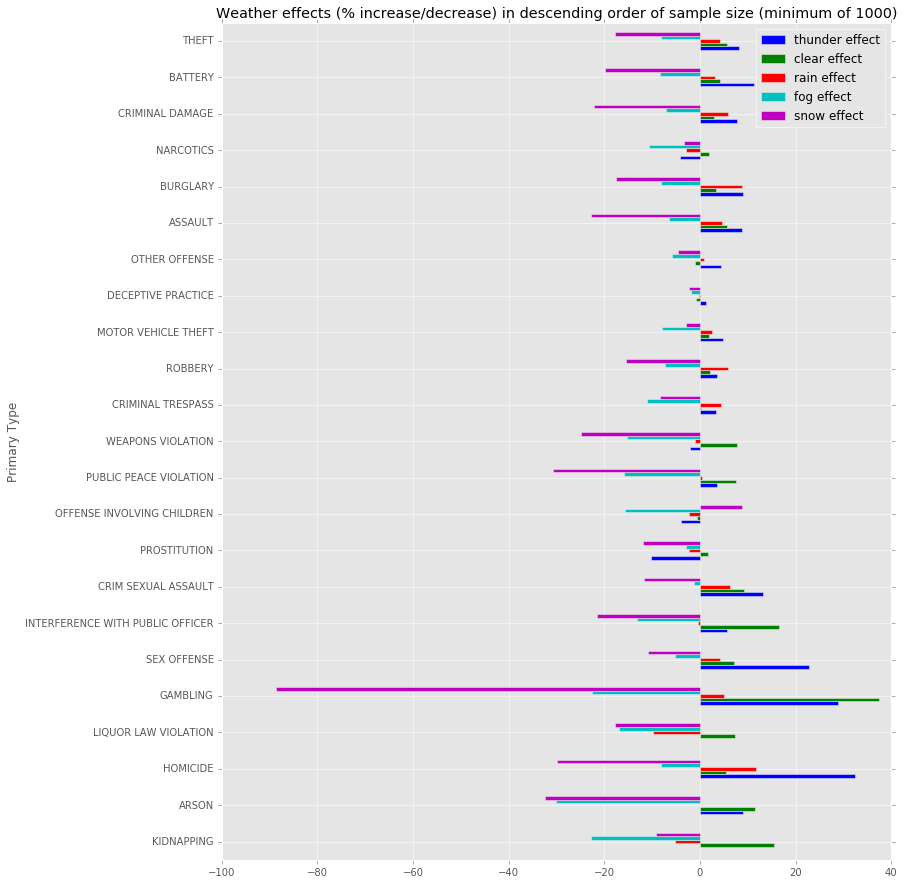

In [23]:
columns = [column for column in comparison_df_truncated.columns if column != 'sample size']
comparison_df_truncated[columns].plot(kind='barh', figsize=(12,15), 
                                      title='Weather effects (% increase/decrease) in descending order of sample size (minimum of 1000)')

### Interesting! It appears as though Thunderstorms and Clear Weather are both associated with an increase in crime rate, while Fog and Snow seem to have the opposite association

In [24]:
comparison_df.describe()

,thunder effect,clear effect,rain effect,fog effect,snow effect,sample size
count,32.00,32.00,32.00,30.00,32.00,33.00
mean,13.36,14.92,2.78,-3.79,-20.30,46305.30
std,28.53,39.81,6.78,23.52,20.91,81279.83
min,-23.91,-40.54,-9.75,-37.89,-88.64,3.00
25%,0.90,1.23,-2.17,-14.77,-24.31,697.00
50%,4.95,5.56,1.85,-8.08,-16.60,6263.00
75%,11.73,12.49,5.80,-3.44,-8.23,68470.00
max,105.45,185.39,26.52,86.34,8.72,340766.00


It now appears as though both temperature and weather events have definite associations with crime rates. However, weather events themselves tend to be associated with certain temperatures. So we need to tease out the event effects from <b>within</b> each temperature range.

Thunderstorms, in particular, seem counterintuitive. How can it be that crime is more likely when there's a thunderstorm?

In [25]:
# What sort of temperature is common during a thunderstorm?
print('Average high temp on thunderstorm days','{:.2f}'.format(combined[combined['Thunderstorm'] == True]['Max TemperatureF'].mean()))
print('Average high temp on non-thunderstorm days','{:.2f}'.format(combined[combined['Thunderstorm'] == False]['Max TemperatureF'].mean()))

Average high temp on thunderstorm days 77.46
Average high temp on non-thunderstorm days 59.32


In [26]:
# Let's build on to the temp_bucket_df we built previously

temp_bucket_df['Clear Days'] = temp_bucket_df.index.map(lambda x: daycount(x,'Clear'))
temp_bucket_df['Clear Rate'] = temp_bucket_df.index.map(lambda x: crimerate(x,'Clear'))

for event in eventlist:
    temp_bucket_df[str(event) + ' Days'] = temp_bucket_df.index.map(lambda x: daycount(x,event))
    temp_bucket_df[str(event) + ' Rate'] = temp_bucket_df.index.map(lambda x: crimerate(x,event))

In [27]:
temp_bucket_df['Clear Effect'] = ((temp_bucket_df['Clear Rate'] / temp_bucket_df['Crime Rate'])-1)*100
for event in eventlist:
    temp_bucket_df[str(event) + ' Effect'] = ((temp_bucket_df[str(event) + ' Rate'] / temp_bucket_df['Crime Rate'])-1)*100
# temp_bucket_df['Temp Effect'] = ((temp_bucket_df['Crime Rate'] / overall)-1)*100
# temp_bucket_df

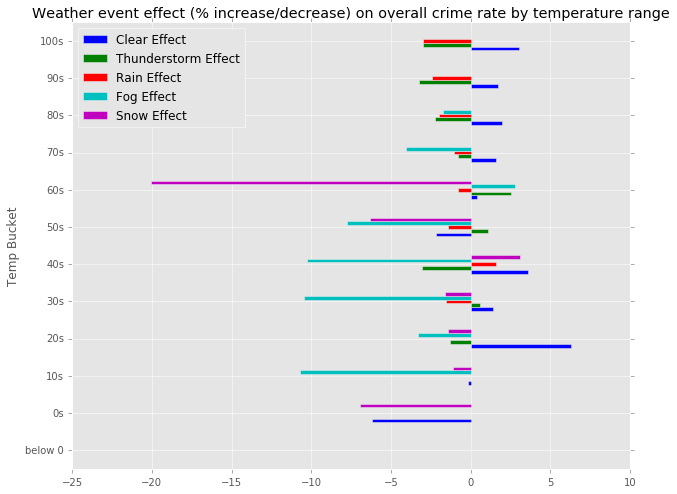

In [28]:
plt.style.use('ggplot')
temp_bucket_df[(['Clear Effect', 'Thunderstorm Effect', 
                 'Rain Effect', 'Fog Effect', 
                 'Snow Effect'])].plot(kind = 'barh', figsize = (10,8),
                                       title = 'Weather event effect (% increase/decrease) on overall crime rate by temperature range')

### A much different story indeed

We can now see that for every weather event <i>within</i> each temperature range, there is almost always
a negative association between weather events and overall crime rate.

Thunderstorms looked like they caused a spike in crime, but it's only because thunderstorms happen
in warmer than average temperatures.

"Clear" days, which were defined as having cloud cover ratings less than 3, are consistently associated with 
higher crime rates, even within a given temperature range.

# 3) Are certain phases of the moon related to higher crime rates?

(Lisa)

# 4) Which criminal activities become more or less likely during specific weather events?

(Scott)

Earlier, we looked at how weather events affect crime rates, but that was without adjusting for temperature. We've learned that temperature really is the driving factor for overall crime rate. But are there particular crime types that become *more* likely for a particular weather event within a certain temperature range?

In [84]:
combined['Date'] = pd.to_datetime(combined['Date']).dt.date

In [124]:
len(combined.groupby(['Date','Primary Type']).get_group((combined.Date[0],'THEFT')))

132

In [132]:
grouped = combined.groupby(['Date', 'Primary Type']).Block.count()


132

In [133]:
sorted_types = comparison_df_truncated.index[::-1]
sorted_types

Index(['THEFT', 'BATTERY', 'CRIMINAL DAMAGE', 'NARCOTICS', 'BURGLARY',
       'ASSAULT', 'OTHER OFFENSE', 'DECEPTIVE PRACTICE', 'MOTOR VEHICLE THEFT',
       'ROBBERY', 'CRIMINAL TRESPASS', 'WEAPONS VIOLATION',
       'PUBLIC PEACE VIOLATION', 'OFFENSE INVOLVING CHILDREN', 'PROSTITUTION',
       'CRIM SEXUAL ASSAULT', 'INTERFERENCE WITH PUBLIC OFFICER',
       'SEX OFFENSE', 'GAMBLING', 'LIQUOR LAW VIOLATION', 'HOMICIDE', 'ARSON',
       'KIDNAPPING'],
      dtype='object', name='Primary Type')

In [137]:
def daily_type_map(d,t,s=grouped):
    try:
        return s[d][t]
    except KeyError:
        return 0
        

In [175]:
templist = []
for t in temp_bucket_df_index:
    for e in eventlist:
        for s in sorted_types:
            factor = (weather_df[(weather_df[e] == True) & (weather_df['temp bucket'] == t)][s].sum()/\
                      weather_df[(weather_df[e] == True) & (weather_df['temp bucket'] == t)][s].count())/\
            (weather_df[(weather_df[e] == False) & (weather_df['temp bucket'] == t)][s].sum()/\
             weather_df[(weather_df[e] == False) & (weather_df['temp bucket'] == t)][s].count())
            if weather_df[(weather_df[e] == True) & (weather_df['temp bucket'] == t)][s].count() > 25 and factor > 1.05:
                templist.append(s)
tempseries = pd.Series(templist)


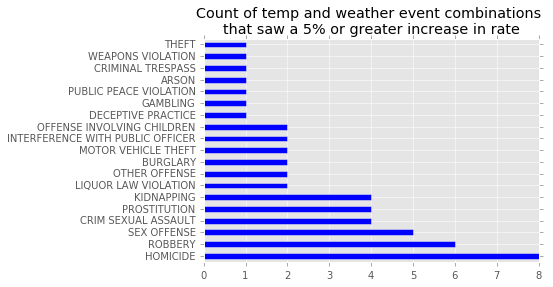

In [182]:
tempseries.value_counts().plot(kind='barh', title='Count of temp and weather event combinations \nthat saw a 5% or greater increase in rate')

It does indeed appear as though Kidnapping, Prostitution, Criminal Sexual Assault, Sex Offense, Robbery, and Homocide become more likely as the weather becomes less pleasant (corrected for temperature). Interesting.

# 5) Is crime influenced more by weather or by season?

(Lisa)

# 6) Is crime less likely to occur on holidays?

(Jay)

# 7) How has the crime rate changed over time? Is the change the same across all crime types?

(Jay)

# 8) Does the day of the month affect crime rate?

(Scott)

It may seem trivial, but it might be worth exploring how the day of the month affects the crime rate

In [183]:
types_df = pd.DataFrame(index=primary_types)
types_df['total'] = types_df.index.map(lambda x: len(combined[combined['Primary Type'] == x]))
types_df.sort_values(by='total', ascending=[0], inplace=True)

In [184]:
types_df.drop(types_df[types_df['total'] < 1000].index, axis=0, inplace=True)

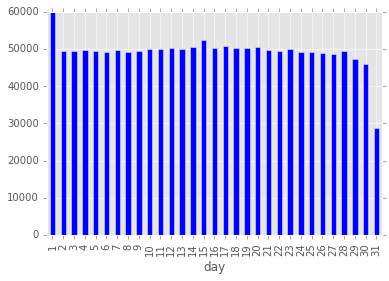

In [191]:
weather_df.groupby('day').crimes.sum().plot(kind='bar')

Right off the bat, it looks like there's a significant spike in crime on the 1st of the month. The 31st sees a huge drop, but that's expected, given that only about half of the months have a 31st day.

The small spike on the 15th, combined with the spike on the 1st, makes me wonder if some crimes are associated with a typical salaried employee's payday.

In [185]:
# Pull crime rate for a given primary type and day of the month
def inclusivedayrate(ptype, day=1, df=combined):
    instances = len(df[(df['Primary Type'] == ptype) & (df['day'] == day)])
    days = len(df[(df['Primary Type'] == ptype) & (df['day'] == day)].Date.unique())
    return instances/days

def exclusivedayrate(ptype, day=1, df=combined):
    instances = len(df[(df['Primary Type'] == ptype) & (df['day'] != day)])
    days = len(df[(df['Primary Type'] == ptype) & (df['day'] != day)].Date.unique())
    return instances/days

In [186]:
types_df['firstrate'] = types_df.index.map(inclusivedayrate)
types_df['otherdaysrate'] = types_df.index.map(exclusivedayrate)
types_df['firstratefactor'] = types_df['firstrate'] / types_df['otherdaysrate']

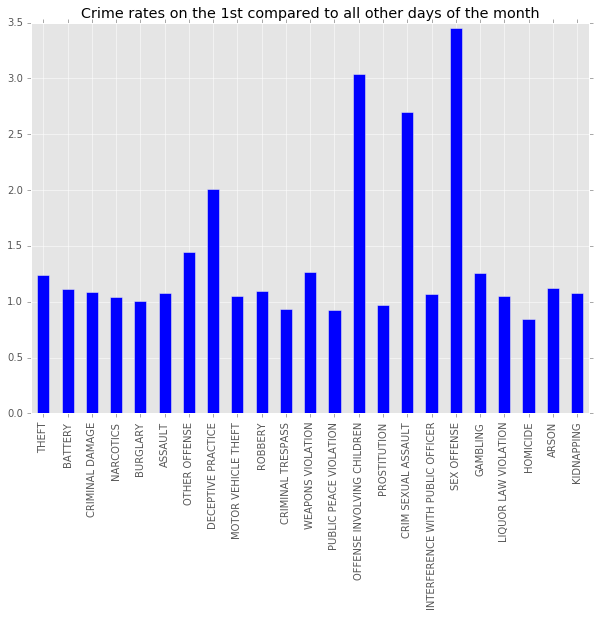

In [187]:
types_df.firstratefactor.plot(kind='bar', title='Crime rates on the 1st compared to all other days of the month', figsize=(10,7))

### Whoa!

There's a huge spike on the 1st of the month for just a few crimes in particular.

Offense involving children could make sense, if we consider that disputes about child support payments could be more likely on the 1st. Descepting Practice may have something to do with swindling people out of their hard-earned paychecks.

Sexual Assault and Sex Offense, however, do not seem to have an obvious connection with the day of the month. It could be that a separate police division handles sex assault and sex offense cases and they have different practices about how cases get filed.

I've actually sent an email to the Chicago PD to ask for help understanding the spike, but have not heard back yet. If I get anything back, I'll include what I learn in this analysis.

# Sandbox
## Any other useful/relevant/interesting findings?

In [29]:
# Everybody!